# Im_reduc example

This is a basic image reduction script based on the data processing techniques taught in the physics 2070 course and York university that were previously carried through with IRAF. This script aims to be the first of many demonstrations of a more automatic system that still retains full user control and more education value than just clicking a button. 

## Imports

The first aspect of every script is importing the external code that the script will 'call to'. These are known as import statements. First we import the main Draco file and then we import the Table and fits libraries from astropy. Next we import the two most fundamental libraries for anything science or computing related in python, numpy and matplotlib.

In [1]:
import draco
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

from astropy.nddata import CCDData
from ccdproc import Combiner
import ccdproc
import astropy.units as u
from astropy.utils.misc import isiterable


## Declaring file prefixes and locations

Here are the standard file prefixes for this reduction script. Data was taken in 8 band filters in December of 2018 of comet 46P Wirtanen (4 filters are clear). Along with 'lights', 'flats' and 'bias' images were taken for reduction.

In [2]:
file_path = 'C:/Users/mucep/Offline/Draco-test/'
im_prefix = 'Draco-'
c46P_prefix = '46P_'
BIAS_suffix = '.BIAS'
FLAT_prefix = 'FLAT_'
FLAT_suffix = '.FLAT'
filters = ['BLUE', 'CLEAR', 'EIGHT', 'GREEN', 'LUMINANCE', 'RED', 'SEVEN', 'SIX']


## Making the master BIAS

Making a master bias image in DRACO is as easy as one line. By feeding the `draco.mast_reduc` function the folder location of the BIAS images, the filename prefix (text before the index numbers), the filename suffix (text after the index numbers), the number of BIAS images taken, and a Boolean value of whether or not to edit out cosmic rays from the BIAS images before stacking (takes extra time to compute), draco will return the master BIAS image which we store as `master_bias`.

By uncommenting the second line will write the master BIAS image to a fits file in the scripts home folder. Future versions of DRACO will better handle file input/output.


In [3]:
master_bias = draco.mast_reduc(file_path + 'Bias/', im_prefix, BIAS_suffix, 10, True)
#fits.writeto('master_bias.fits', master_bias)


## Setting up the FLATS in memory



In [4]:
reduc_filters =  ['BLUE', 'CLEAR', 'LUMINANCE', 'SEVEN', 'SIX']
size = master_bias.shape
im_count = 5
master_i_Flat = []


## Reading and reducing the FLATS into Master FLATS




Starting  BLUE  filter...
filter:  Draco-BLUE- , flat:  1
filter:  Draco-BLUE- , flat:  2
filter:  Draco-BLUE- , flat:  3
filter:  Draco-BLUE- , flat:  4
filter:  Draco-BLUE- , flat:  5
filter:  Draco-BLUE- , flat:  6
filter:  Draco-BLUE- , flat:  7
filter:  Draco-BLUE- , flat:  8
filter:  Draco-BLUE- , flat:  9
reduced:  Draco-BLUE-


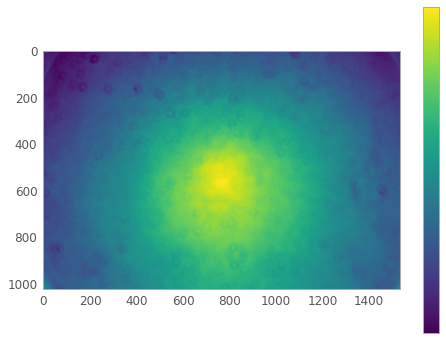

norm_factor:  [1386.60493978]

Starting  CLEAR  filter...
filter:  Draco-CLEAR- , flat:  1
filter:  Draco-CLEAR- , flat:  2
filter:  Draco-CLEAR- , flat:  3
filter:  Draco-CLEAR- , flat:  4
filter:  Draco-CLEAR- , flat:  5
filter:  Draco-CLEAR- , flat:  6
filter:  Draco-CLEAR- , flat:  7
filter:  Draco-CLEAR- , flat:  8
filter:  Draco-CLEAR- , flat:  9
reduced:  Draco-CLEAR-


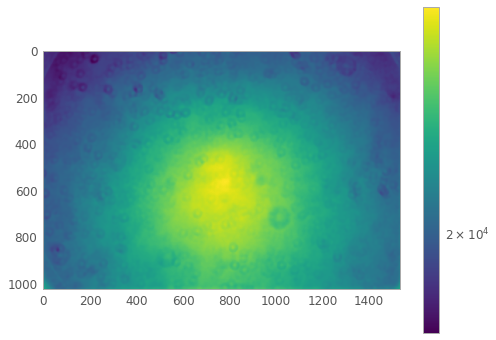

norm_factor:  [20764.2593316]

Starting  LUMINANCE  filter...
filter:  Draco-LUMINANCE- , flat:  1
filter:  Draco-LUMINANCE- , flat:  2
filter:  Draco-LUMINANCE- , flat:  3
filter:  Draco-LUMINANCE- , flat:  4
filter:  Draco-LUMINANCE- , flat:  5
filter:  Draco-LUMINANCE- , flat:  6
filter:  Draco-LUMINANCE- , flat:  7
filter:  Draco-LUMINANCE- , flat:  8
filter:  Draco-LUMINANCE- , flat:  9
reduced:  Draco-LUMINANCE-


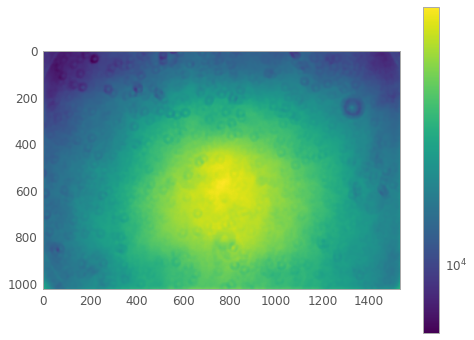

norm_factor:  [10439.39507378]

Starting  SEVEN  filter...
filter:  Draco-SEVEN- , flat:  1
filter:  Draco-SEVEN- , flat:  2
filter:  Draco-SEVEN- , flat:  3
filter:  Draco-SEVEN- , flat:  4
filter:  Draco-SEVEN- , flat:  5
filter:  Draco-SEVEN- , flat:  6
filter:  Draco-SEVEN- , flat:  7
filter:  Draco-SEVEN- , flat:  8
filter:  Draco-SEVEN- , flat:  9
reduced:  Draco-SEVEN-


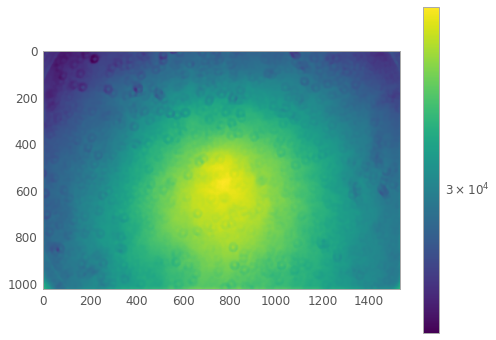

norm_factor:  [29177.79014757]

Starting  SIX  filter...
filter:  Draco-SIX- , flat:  1
filter:  Draco-SIX- , flat:  2
filter:  Draco-SIX- , flat:  3
filter:  Draco-SIX- , flat:  4
filter:  Draco-SIX- , flat:  5
filter:  Draco-SIX- , flat:  6
filter:  Draco-SIX- , flat:  7
filter:  Draco-SIX- , flat:  8
filter:  Draco-SIX- , flat:  9
reduced:  Draco-SIX-


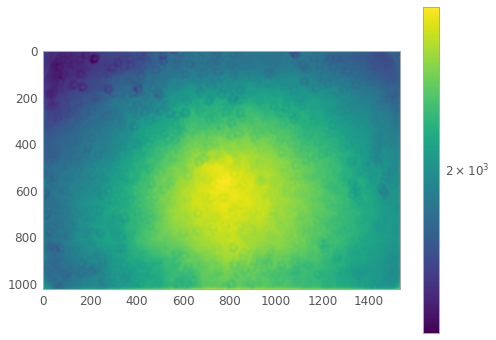

norm_factor:  [1934.71605089]


In [5]:
for i in range(len(reduc_filters)):
    print('\nStarting ', reduc_filters[i], ' filter...')
    flat_i = draco.mast_flat(file_path + 'Flats/' + reduc_filters[i] + '/', im_prefix + reduc_filters[i] + '-', FLAT_suffix, 10, False, master_bias)
    #flat_i = draco.imarith(flat_i, '-', master_bias)
    flat_i = draco.norm_flat(np.array(flat_i.data))
    master_i_Flat.append(flat_i)
    #fits.writeto('master_' + reduc_filters[i] + '_Flat.fits', master_i_Flat[i])


## Reading and reducing the LIGHTS into Fully Reduced LIGHTS



In [6]:
light_n = []
series_all = []
for n in  range(len(reduc_filters)):
    series_n = draco.get_series(file_path + 'Lights/', c46P_prefix + reduc_filters[n] + '-', '', 5, False)
    series_n = draco.series_arith(series_n, '-', master_bias, 5)
    series_n = draco.series_arith(series_n, '/', master_i_Flat[n], 5)
    sky = draco.sky_est(series_n)
    series_n = draco.series_arith(series_n, '-', sky, 5)
    series_all.append(series_n)
    combine_list = []
    for t in range(5):
        combine_list.append(CCDData(series_n[:, :, t], unit=u.adu))
    combine = Combiner(combine_list)
    reduced_filter_nocr = combine.average_combine()
    reduced_filter = ccdproc.cosmicray_lacosmic(reduced_filter_nocr)
    light_n.append(reduced_filter)
    print(reduc_filters[n], ' Filter lights complete.')

BLUE  Filter lights complete.
CLEAR  Filter lights complete.
LUMINANCE  Filter lights complete.
SEVEN  Filter lights complete.
SIX  Filter lights complete.


## Plotting a sample image



(5, 1023, 1536, 5)


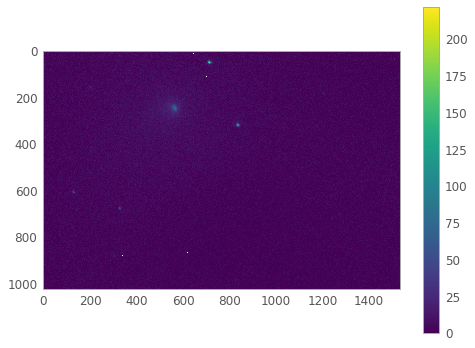

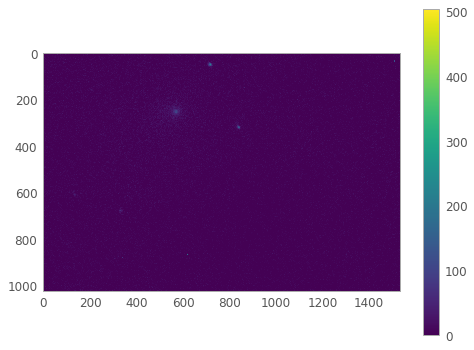

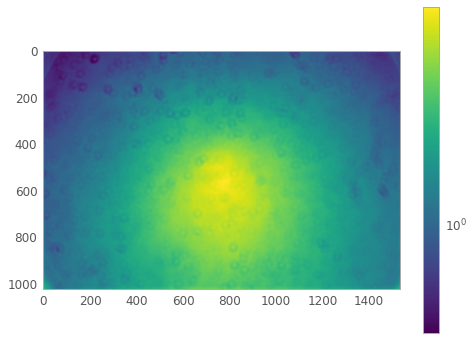

In [7]:
series_all = np.array(series_all)
print(series_all.shape)
plt_series = series_all[3, :, :, 1]
draco.plt_fits(light_n[3], 'viridis')
draco.plt_fits(plt_series, 'viridis')
draco.plt_flat(master_i_Flat[3], 'viridis')

## Check that DRACO and IRAF agree

It is important to make sure that DRACO and IRAF both give the same result. This first test will check whether the BIAS images constructed are the same, and whether the master FLATS images are the same.

0.5219696494803109


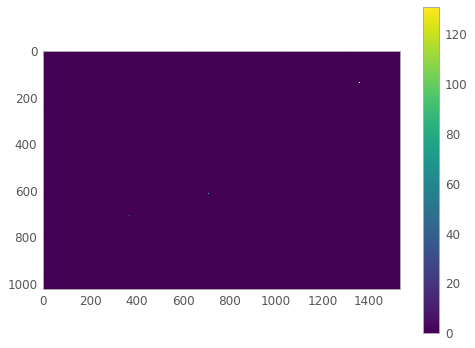

In [8]:
master_bias_IRAF = fits.getdata('MasterBias_IRAF.fits')
#draco.norm_flat(np.array(flat_i.data))
ag = np.abs(master_bias_IRAF - master_bias)
print(np.mean(ag))
draco.plt_fits(ag, 'viridis')

norm_factor:  [11223.]

Difference
0.026650492117251484

IRAF 
1.0253289

DRACO
1.051979426255691

Difference


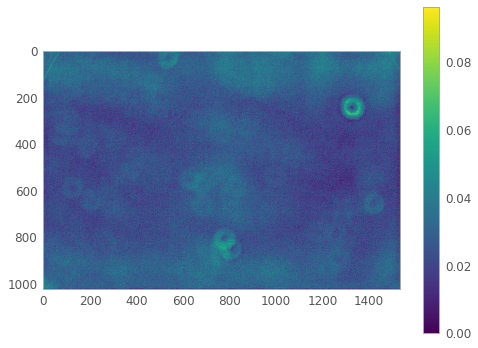


IRAF 


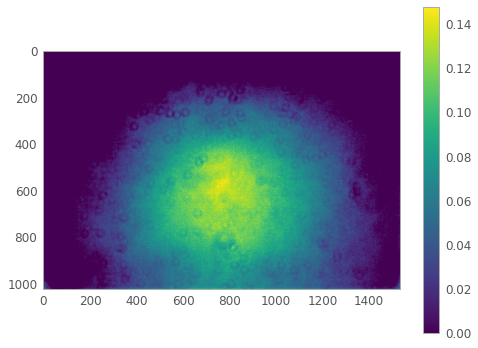


DRACO


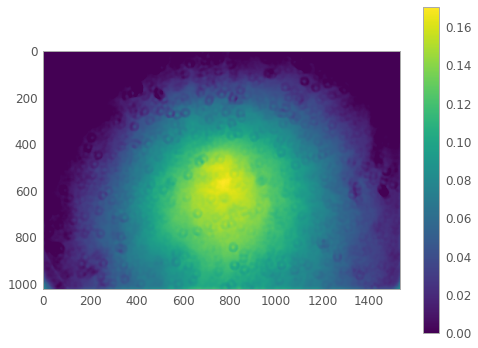

In [9]:
master_Bflat_IRAF = draco.norm_flat(np.array(fits.getdata('MasterLuminanceFlat_IRAF.fits')))

ag2 = np.abs((master_Bflat_IRAF) - master_i_Flat[3])
print('\nDifference')
print(np.mean(ag2))
print('\nIRAF ')
print(np.mean(master_Bflat_IRAF))
print('\nDRACO')
print(np.mean(master_i_Flat[3]))
print('\nDifference')
draco.plt_fits(ag2, 'viridis')
print('\nIRAF ')
draco.plt_fits(np.log(master_Bflat_IRAF), 'viridis')
print('\nDRACO')
draco.plt_fits(np.log(master_i_Flat[3]), 'viridis')
# fits.writeto('cool_flat_diff.fits', ag2)